# 參數設定 (VMD + 使用訊號分解 EEMD)

In [1]:
import os

labels = ['GroupCount']
model_type = 1 # 使用模型
predicteds = [5] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1
vmd_k = 8 # VMD分解層數
std_num = 1 # 標準差倍數
sigma = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = False # 是否使用 EMD，False 則使用 EEMD 
 
model_dir = 'VMD_DecompEEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.x_scaler.pkl
y_scaler_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.y_scaler.pkl
model_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.model.keras
result_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.result.json


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[5],156009964,1063367,873569,9,2531,64,2604,0,0,0,0,0,0,2604
1,2023-04-03,[5],266983699,1670644,1289435,33,3928,75,4034,2,0,0,0,0,0,4036
2,2023-04-04,[5],198064713,1377806,881103,8,3552,72,3630,2,0,0,0,0,0,3632
3,2023-04-05,[5],275355693,1804631,1005218,8,4270,101,4378,1,0,0,0,0,0,4379
4,2023-04-06,[5],226168175,2059599,1254506,40,5491,82,5612,0,0,0,1,0,0,5613


# VMD 訊號分解

In [5]:
data_source = df_source[labels].values
u = lstm.vmd_decomposition(data_source, K = vmd_k)

print(data_source.shape)
print(u.shape)  

(395, 1)
(8, 394)


# 繪製 VMD 訊號分解圖

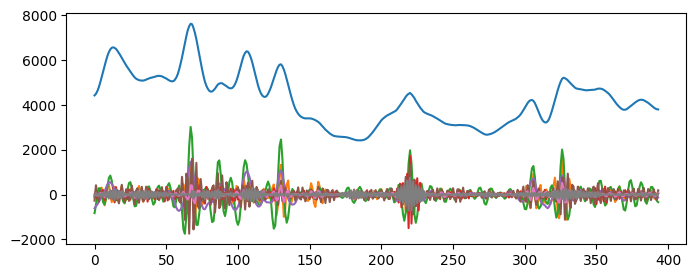

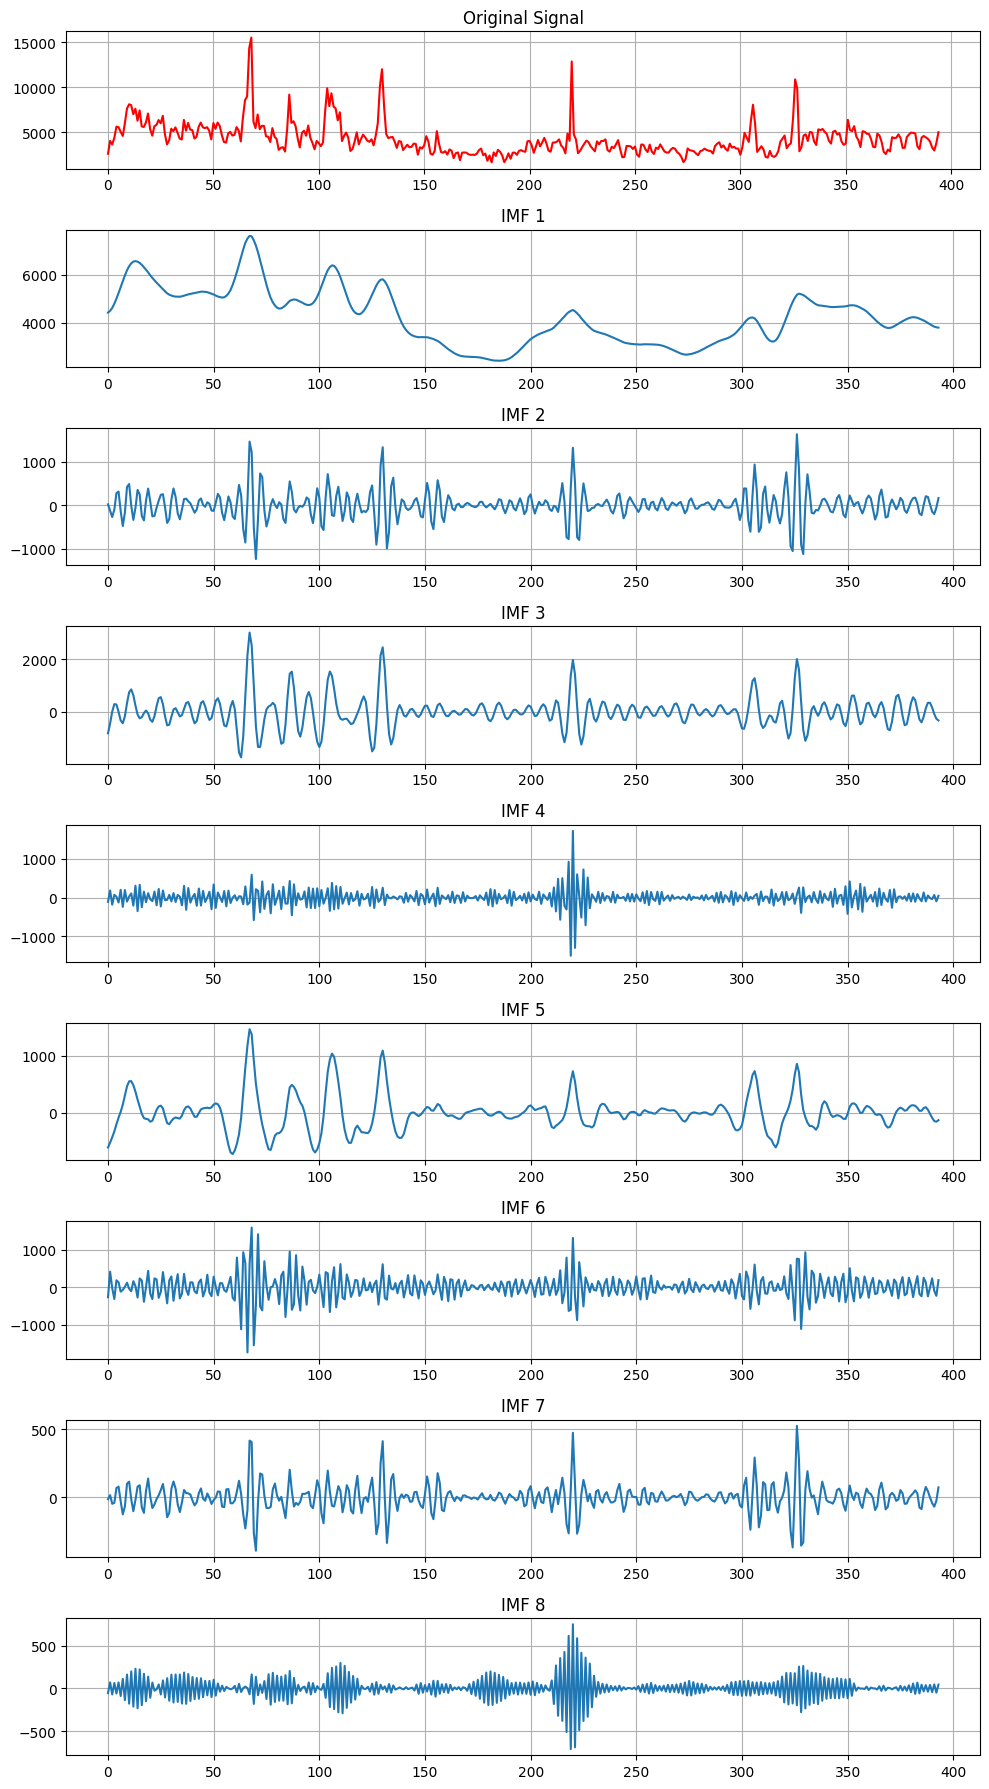

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(u.T)  
plt.show()

lstm.plot_imfs_with_original(data_source, u) 

# VMD 異常資料前處理

IMFs 的數量: 8, 每個 IMF 的長度: 394
將異常部分的值進行平滑處理，imf 1 有 125 個異常點
將異常部分的值進行平滑處理，imf 2 有 80 個異常點
將異常部分的值進行平滑處理，imf 3 有 74 個異常點
將異常部分的值進行平滑處理，imf 4 有 72 個異常點
將異常部分的值進行平滑處理，imf 5 有 88 個異常點
將異常部分的值進行平滑處理，imf 6 有 72 個異常點
將異常部分的值進行平滑處理，imf 7 有 69 個異常點
將異常部分的值進行平滑處理，imf 8 有 94 個異常點
(394,)
(394,)
(394,)
MAE: 312.2919
MAPE: 0.0609


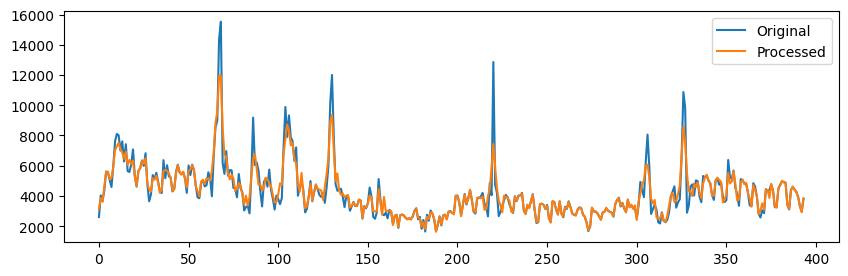

In [7]:
processed_signal = lstm.preprocess_smooth_signal_imfs(u, sigma=sigma, std_threshold=std_num)
original_signal = np.sum(u, axis=0)
# VMD 分解後會少最後一個值，因此要把原始資料的最後一個值去掉
original_data = data_source[:-1].reshape(-1)

print(original_data.shape)
print(processed_signal.shape) 
print(original_signal.shape)

mae = mean_absolute_error(original_data, processed_signal)
mape = mean_absolute_percentage_error(original_signal, processed_signal)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')

plt.figure(figsize=(10, 3))
plt.plot(original_data, label='Original') 
plt.plot(processed_signal, label='Processed')
plt.legend()
plt.show() 

# EEMD 訊號分解

# 訊號分解
EEMD


IMFs shape : (8, 394)
eIMFs shape : (8, 394)
residue shape : (394,)


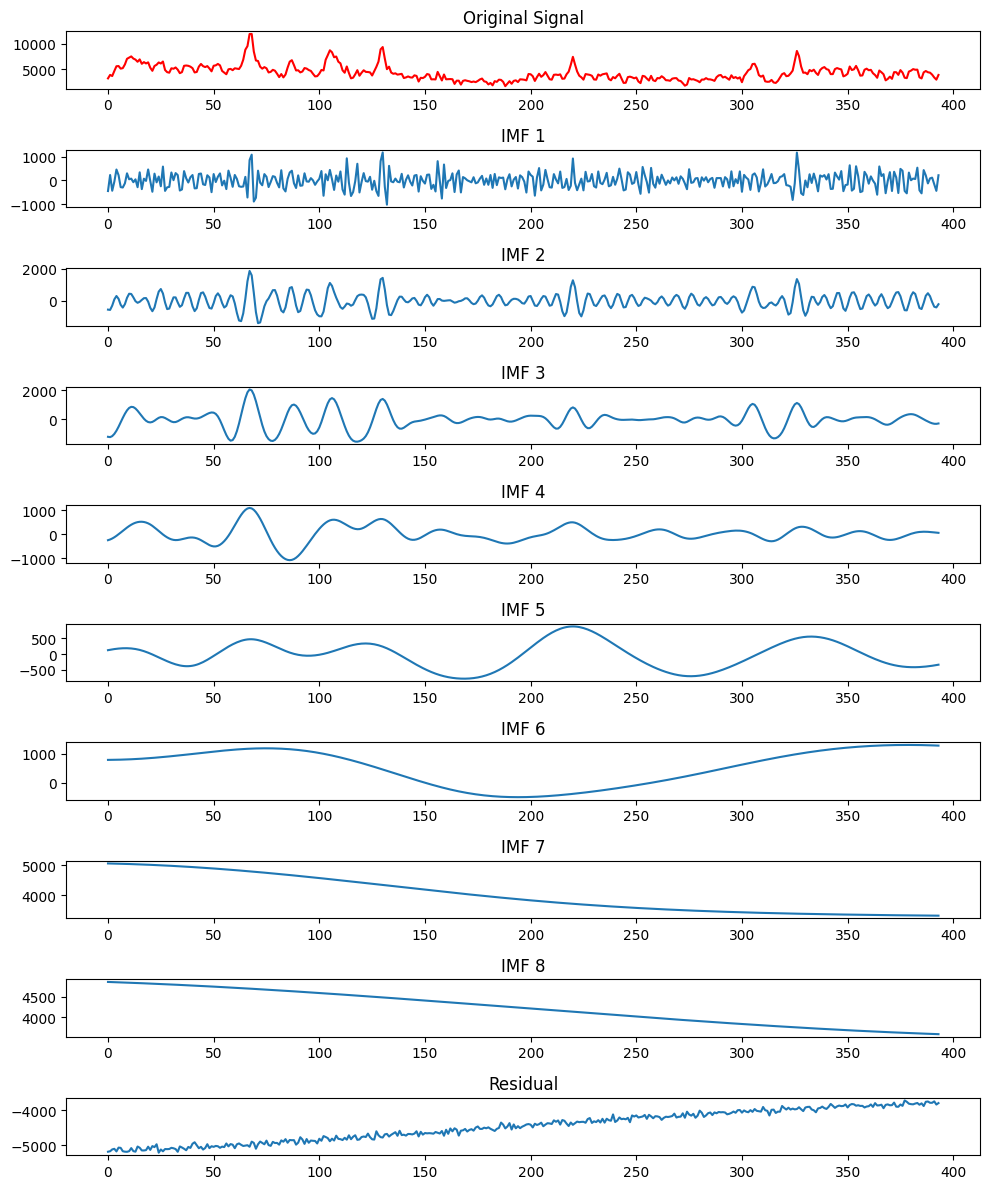

In [8]:
eIMFs, residue, imfs = lstm.decomposition(processed_signal, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [9]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
----------------------------------------------------------------

# 最小最大正規化

In [10]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)
 
    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [11]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [12]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [13]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：1
LSTM


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [14]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [15]:
for i in range(len(models)):
    print_step(i + 1)  
    
    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
---------

# 預測

In [16]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [17]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (300, 1)
actual_inverse_train.shape : (300, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (300, 1)
actual_inverse_train.shape : (300, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [18]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(processed_signal, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (315,)
y_train.shape: (315,)
x_val.shape: (39,)
y_val.shape: (39,)
x_test.shape: (40,)
y_test.shape: (40,)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (300, 1)
y_lstm_origin_train.shape : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14)
y_lstm_origin_val.shape : (24, 1)


In [19]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (300, 1)
actual_inverse_train_sum (300, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [20]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180 - mean_absolute_percentage_error: 26.3480

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - mean_absolute_percentage_error: 719278.1875


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.10798，MAPE:3143727708460.653，MSE:0.01836，RMSE:0.1355，R square:0.16925
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:238.23491，MAPE:1.65579，MSE:89377.34294，RMSE:298.96044，R square:0.16925

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0199 - mean_absolute_percentage_error: 28.9703

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199 - mean_absolute_percentage_error: 28.9703


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.12012，MAPE:0.2897，MSE:0.01993，RMSE:0.14118，R square:-0.06197
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:265.02777，MAPE:3.5603，MSE:97023.96246，RMSE:311.4867，R square:-0.06197

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - mean_absolute_percentage_error: 29.6589

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183 - mean_absolute_percentage_error: 29.6589


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.11399，MAPE:0.29659，MSE:0.01826，RMSE:0.13514，R square:0.27678
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:251.50389，MAPE:1.88211，MSE:88899.61116，RMSE:298.16038，R square:0.27678

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mean_absolute_percentage_error: 9.0989

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - mean_absolute_percentage_error: 379042.0312


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.03674，MAPE:980688449481.5154，MSE:0.00226，RMSE:0.0475，R square:0.88969
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:119.70644，MAPE:1.87936，MSE:23962.65，RMSE:154.79874，R square:0.88969

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_absolute_percentage_error: 10.1993

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_absolute_percentage_error: 10.1993


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.03741，MAPE:0.10199，MSE:0.00206，RMSE:0.04542，R square:0.86316
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:121.89005，MAPE:0.65381，MSE:21906.48737，RMSE:148.0084，R square:0.86316

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_absolute_percentage_error: 8.1347

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 8.1347


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03141，MAPE:0.08135，MSE:0.00151，RMSE:0.0389，R square:0.88928
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:102.35587，MAPE:6.83996，MSE:16067.48061，RMSE:126.75757，R square:0.88928

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3013e-04 - mean_absolute_percentage_error: 2.1392

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4035e-04 - mean_absolute_percentage_error: 107119.5000


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.01099，MAPE:468156524352.9514，MSE:0.00021，RMSE:0.01454，R square:0.99264
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:39.56832，MAPE:0.68082，MSE:2743.75443，RMSE:52.38086，R square:0.99264

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5242e-04 - mean_absolute_percentage_error: 2.6188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5242e-04 - mean_absolute_percentage_error: 2.6188


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01014，MAPE:0.02619，MSE:0.00015，RMSE:0.01235，R square:0.95151
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:36.51535，MAPE:0.75102，MSE:1976.89891，RMSE:44.46233，R square:0.95151

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3329e-05 - mean_absolute_percentage_error: 1.0812

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3329e-05 - mean_absolute_percentage_error: 1.0812


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00455，MAPE:0.01081，MSE:3e-05，RMSE:0.00577，R square:0.99304
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:16.39937，MAPE:0.34111，MSE:432.27136，RMSE:20.79114，R square:0.99304

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2210e-04 - mean_absolute_percentage_error: 2.7150

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6737e-04 - mean_absolute_percentage_error: 7844.3726


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.01053，MAPE:26865244132.72245，MSE:0.00014，RMSE:0.01197，R square:0.99516
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:22.90568，MAPE:0.54873，MSE:678.29274，RMSE:26.04405，R square:0.99516

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1028e-04 - mean_absolute_percentage_error: 1.9100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1028e-04 - mean_absolute_percentage_error: 1.9100


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00983，MAPE:0.0191，MSE:0.00011，RMSE:0.0105，R square:0.97139
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:21.39356，MAPE:0.48465，MSE:521.89921，RMSE:22.84511，R square:0.97139

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0945e-04 - mean_absolute_percentage_error: 2.1141

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0945e-04 - mean_absolute_percentage_error: 2.1141


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.0103，MAPE:0.02114，MSE:0.00011，RMSE:0.01046，R square:0.96821
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:22.40672，MAPE:0.4068，MSE:517.93064，RMSE:22.75809，R square:0.96821

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4405e-05 - mean_absolute_percentage_error: 1.2020

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0910e-05 - mean_absolute_percentage_error: 12435.5928


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00665，MAPE:68217991769.42629，MSE:6e-05，RMSE:0.00755，R square:0.9992
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:10.94005，MAPE:0.10418，MSE:154.40308，RMSE:12.4259，R square:0.9992

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5633e-05 - mean_absolute_percentage_error: 1.3613

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5633e-05 - mean_absolute_percentage_error: 1.3613


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00977，MAPE:0.01361，MSE:0.0001，RMSE:0.00978，R square:0.98449
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:16.07564，MAPE:0.04418，MSE:258.91527，RMSE:16.09084，R square:0.98449

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4651e-05 - mean_absolute_percentage_error: 2.0669

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4651e-05 - mean_absolute_percentage_error: 2.0669


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00495，MAPE:0.02067，MSE:2e-05，RMSE:0.00496，R square:0.93689
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:8.14195，MAPE:0.02157，MSE:66.73887，RMSE:8.16939，R square:0.93689

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5070e-05 - mean_absolute_percentage_error: 0.7526

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3358e-05 - mean_absolute_percentage_error: 277.4922


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00185，MAPE:1922333409.2984，MSE:1e-05，RMSE:0.00253，R square:0.99994
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:3.33243，MAPE:0.02293，MSE:20.79307，RMSE:4.55994，R square:0.99994

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1634e-05 - mean_absolute_percentage_error: 0.3692

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1634e-05 - mean_absolute_percentage_error: 0.3692


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00337，MAPE:0.00369，MSE:1e-05，RMSE:0.00341，R square:0.98925
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:6.09271，MAPE:0.0053，MSE:37.91566，RMSE:6.15757，R square:0.98925

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2151e-05 - mean_absolute_percentage_error: 0.5687

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2151e-05 - mean_absolute_percentage_error: 0.5687


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00567，MAPE:0.00569，MSE:3e-05，RMSE:0.00567，R square:-1.45739
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:10.22929，MAPE:0.00787，MSE:104.78413，RMSE:10.23641，R square:-1.45737

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1823e-06 - mean_absolute_percentage_error: 0.2438

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3009e-06 - mean_absolute_percentage_error: 0.3649


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00173，MAPE:0.0043，MSE:1e-05，RMSE:0.00231，R square:0.99994
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:3.02338，MAPE:0.00068，MSE:16.40272，RMSE:4.05003，R square:0.99994

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3021e-06 - mean_absolute_percentage_error: 6.0588

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3021e-06 - mean_absolute_percentage_error: 6.0588


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00151，MAPE:0.06059，MSE:0.0，RMSE:0.00152，R square:0.89999
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:2.64891，MAPE:0.00079，MSE:7.05176，RMSE:2.65551，R square:0.89999

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0979e-06 - mean_absolute_percentage_error: 82019.2031

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0979e-06 - mean_absolute_percentage_error: 82019.2031


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00202，MAPE:368978459362.1753，MSE:0.0，RMSE:0.00202，R square:0.53738
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:3.5421，MAPE:0.00107，MSE:12.55287，RMSE:3.543，R square:0.53738

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6013e-07 - mean_absolute_percentage_error: 0.0420

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0892e-07 - mean_absolute_percentage_error: 0.0674


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00042，MAPE:0.00081，MSE:0.0，RMSE:0.00049，R square:1.0
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.52293，MAPE:0.00012，MSE:0.37855，RMSE:0.61526，R square:1.0

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6788e-06 - mean_absolute_percentage_error: 1.4321

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6788e-06 - mean_absolute_percentage_error: 1.4321


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00129，MAPE:0.01432，MSE:0.0，RMSE:0.0013，R square:0.99268
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1.60484，MAPE:0.00043，MSE:2.60307，RMSE:1.6134，R square:0.99268

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9628e-06 - mean_absolute_percentage_error: 67212.3828

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9628e-06 - mean_absolute_percentage_error: 67212.3828


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00172，MAPE:302618026967.21674，MSE:0.0，RMSE:0.00172，R square:0.97807
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:2.14322，MAPE:0.00059，MSE:4.59388，RMSE:2.14333，R square:0.97807

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_absolute_percentage_error: 2673475.2500

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mean_absolute_percentage_error: 739419.8125 


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.0335，MAPE:1284269824191.2869，MSE:0.00172，RMSE:0.04142，R square:0.96872
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:50.63232，MAPE:0.01113，MSE:3920.01915，RMSE:62.61006，R square:0.96872

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 3.2188

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 3.2188


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02717，MAPE:0.03219，MSE:0.00148，RMSE:0.03843，R square:-0.0105
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:41.07018，MAPE:0.01043，MSE:3373.78616，RMSE:58.0843，R square:-0.0105

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mean_absolute_percentage_error: 3.6417

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 3.6417


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03361，MAPE:0.03642，MSE:0.00155，RMSE:0.03936，R square:-0.54738
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:50.80295，MAPE:0.01329，MSE:3538.89591，RMSE:59.48862，R square:-0.54738

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:254.91102，MAPE:0.06576，MSE:107104.7449，RMSE:327.26861，R square:0.95733

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:245.82719，MAPE:0.05425，MSE:93196.71688，RMSE:305.28137，R square:0.68747

------------------------------------------------------------------------
合併後 Test Evaluate
-----------------------------------------------------------------------

# 顯示原始數據圖表

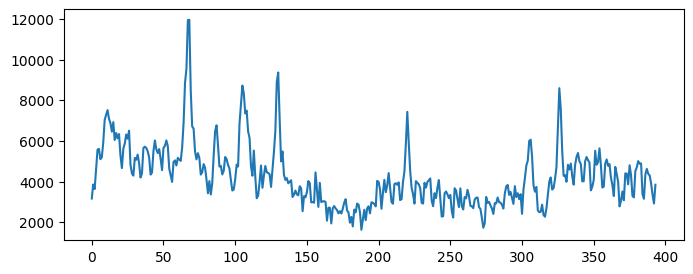

In [21]:
plt.figure(figsize=(8, 3))
plt.plot(processed_signal)
plt.show()

## 訓練集

原始資料 (315,)
[2493.65877498 2513.20791131 2862.28812355]
原始資料2 (300, 1)
[[2493.65877498]
 [2513.20791131]
 [2862.28812355]]
還原原始資料 (300, 1)
[[-4144.4971255 ]
 [-3979.80456843]]


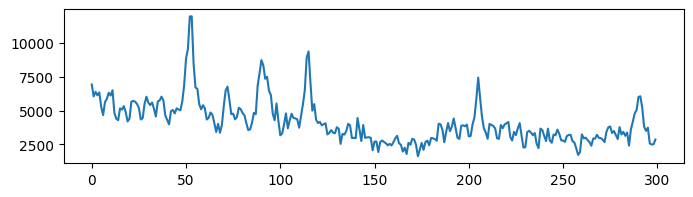

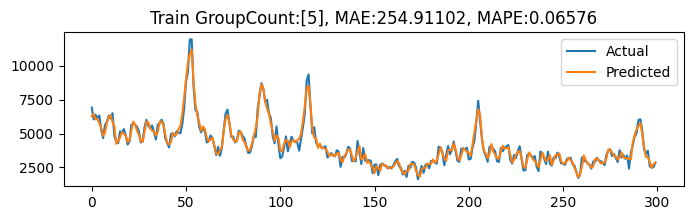

In [22]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39,)
[5514.9731393  4827.39957884 4958.91215016]
原始資料2 (24, 1)
[[5514.9731393 ]
 [4827.39957884]
 [4958.91215016]]
還原原始資料 (24, 1)
[[-3813.22258644]
 [-3821.62430034]]


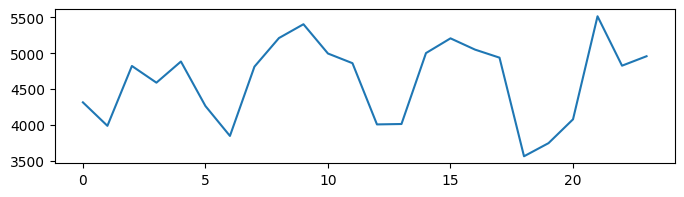

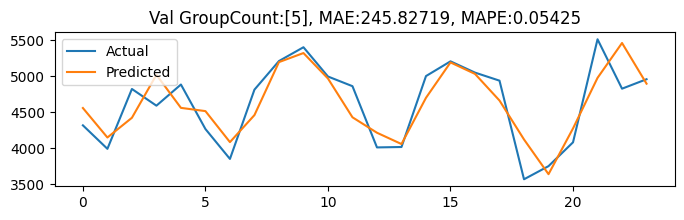

In [23]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40,)
[3344.23380158 2919.08384103 3844.03124162]
原始資料2 (25, 1)
[[3344.23380158]
 [2919.08384103]
 [3844.03124162]]
還原原始資料 (25, 1)
[[-3827.91340609]
 [-3785.38933986]]
Test GroupCount:[5], BatchSize:14, MAE:258.34401, MAPE:0.0667


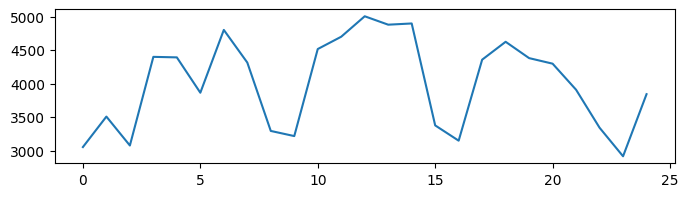

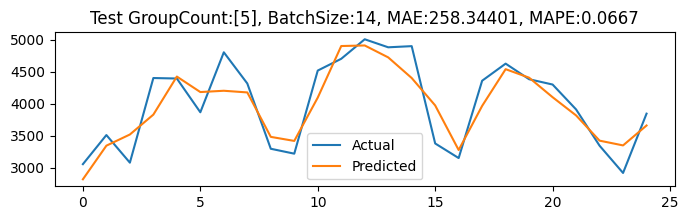

In [24]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [25]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'VMD_DecompEEMD', 'labels': ['GroupCount'], 'model_type': 1, 'predicteds': [5], 'batch_size': 14, 'train_mae': 254.91102, 'train_mape': 0.06576, 'test_mae': 258.34401, 'test_mape': 0.0667, 'kfold': None, 'imfs': 9}
儲存評估結果到 VMD_DecompEEMD/_Model/GroupCount_mt1_data5_batch14.result.json
